In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
dataset = '../datasets/Boston.csv'
data = pd.read_csv(dataset, index_col=0)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [4]:
lstat_aug = pd.concat([data.lstat, pd.Series(np.ones(data.lstat.shape), index=data.lstat.index, name='intercept')], axis=1)

In [5]:
medv_on_lstat = LinearRegression().fit(data.lstat.values.reshape(-1, 1), data.medv)
medv_on_lstat.coef_, medv_on_lstat.intercept_

(array([-0.95004935]), 34.5538408793831)

In [6]:
def add_intercept_term(X):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return pd.concat([X, pd.Series(np.ones(data.lstat.shape), index=X.index, name='intercept')], axis=1)
    elif isinstance(X, np.ndarray):
        return pd.concat([pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X.shape[1])]), pd.Series(np.ones(X.shape[0]), name='intercept')], axis=1)
    else:
        return pd.concat([pd.Series(X, name='X1'), pd.Series(np.ones(len(X)), name='intercept')], axis=1)

In [7]:
def report_model(model, X, y):
    results = {}
    pred_y = model.predict(X)
    residuals = y - pred_y
    residual_stats = pd.Series(residuals).describe()
    results['Residual stats'] = residual_stats
    
    RSS = residuals.T @ residuals
    results['RSS'] = RSS
    
    resid_from_mean = y - y.mean()
    TSS = resid_from_mean.T @ resid_from_mean
    results['TSS'] = TSS
    
    R_squared = 1 - RSS / TSS
    results['R squared'] = R_squared
    
    F_score = ((TSS - RSS) / (X.shape[1])) / (RSS / (X.shape[0] - X.shape[1] - 1))
    results['F_score'] = F_score
    
    sigma_squared_hat = RSS / (X.shape[0] - X.shape[1] - 1)
    results['Sigma squared estimation'] = sigma_squared_hat
    
    RSE = sigma_squared_hat ** 0.5
    results['RSE'] = RSE
    
    aug_X = add_intercept_term(X)
    var_beta_hat = np.linalg.inv(aug_X.T @ aug_X) * sigma_squared_hat
    results['Betha variance estimation'] = var_beta_hat
    
    se = []
    for p_ in range(X.shape[1] + 1):
        standard_error = var_beta_hat[p_, p_] ** 0.5
        se.append(standard_error)
        results[f"SE(beta_hat_{p_})"] = standard_error
    [print(f'{k}: {v}') for k, v in results.items()]
    return results

In [8]:
results = report_model(medv_on_lstat, data.lstat.values.reshape(-1, 1), data.medv)

Residual stats: count    5.060000e+02
mean    -5.673108e-15
std      6.209603e+00
min     -1.516745e+01
25%     -3.989612e+00
50%     -1.318186e+00
75%      2.033701e+00
max      2.450013e+01
Name: medv, dtype: float64
RSS: 19472.381418326433
TSS: 42716.29541501976
R squared: 0.5441462975864799
F_score: 601.6178711098956
Sigma squared estimation: 38.63567741731435
RSE: 6.2157604053980675
Betha variance estimation: [[ 0.00150028 -0.01898311]
 [-0.01898311  0.31654954]]
SE(beta_hat_0): 0.038733416212639364
SE(beta_hat_1): 0.5626273549884322


In [9]:
def intervals(model, X, model_stats):
    if isinstance(X, (float, int)):
        X = np.array(X).reshape(-1, 1)
    t = 1.9647
    results = {}

    predictions = model.predict(X)
    aug_X = add_intercept_term(X)
    
    cov = model_stats['Betha variance estimation']
    model_var = model_stats['Sigma squared estimation']
    
    se = (aug_X * np.dot(cov, aug_X.T).T).sum(1)
    
    CI = t * se ** 0.5
    PI = t * (se + model_var) ** 0.5
    results['Confidence intervals'] = np.array([predictions - CI, predictions + CI]).T
    results['Prediction intervals'] = np.array([predictions - PI, predictions + PI]).T
    
    [print(f'{k}: \n{v}') for k, v in results.items()]
    return results

In [10]:
predictions = intervals(medv_on_lstat, np.array([5, 10, 15]).reshape(-1, 1), results)

Confidence intervals: 
[[29.00740464 30.59978358]
 [24.47412671 25.63256797]
 [19.73158292 20.87461823]]
Prediction intervals: 
[[17.56556268 42.04162554]
 [12.82751436 37.27918032]
 [ 8.07763011 32.52857103]]


In [11]:
y = data.medv
X = data.lstat.values.reshape(-1, 1)
y_pred = medv_on_lstat.predict(X)

In [12]:
import statsmodels.api as sm

In [13]:
mod = sm.OLS(y, sm.add_constant(X)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 29 Aug 2020   Prob (F-statistic):           5.08e-88
Time:                        19:03:43   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.000      33.448      35.659
x1            -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
res = mod.get_prediction(sm.add_constant([5, 10, 15]))
res.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,25.053347,0.294814,24.474132,25.632563,12.827626,37.279068
2,20.303101,0.290893,19.731588,20.874613,8.077742,32.528459


<AxesSubplot:xlabel='lstat', ylabel='medv'>

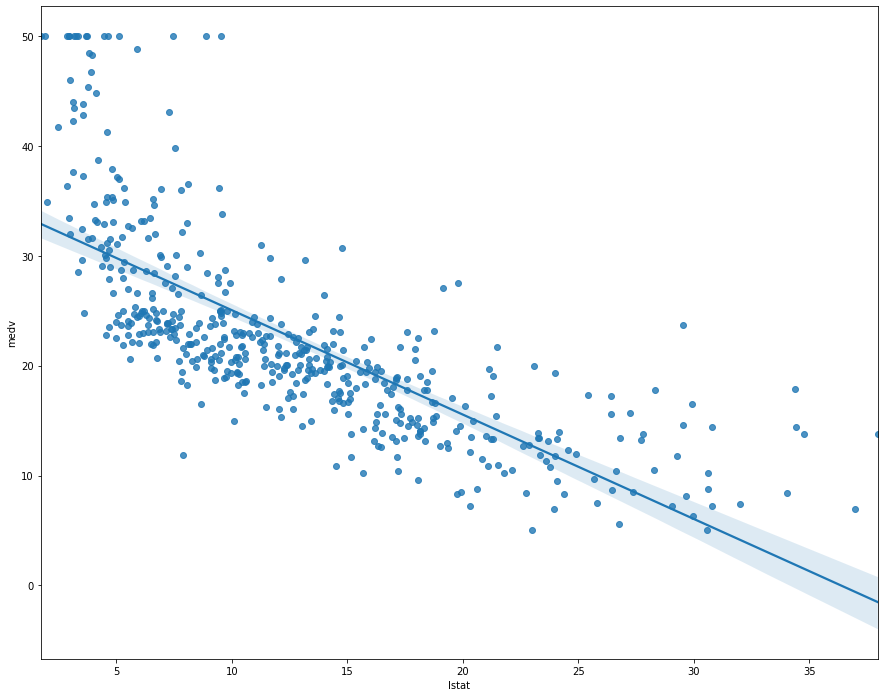

In [15]:
_ = plt.figure(figsize=(15, 12))
sns.regplot(data.lstat, data.medv)

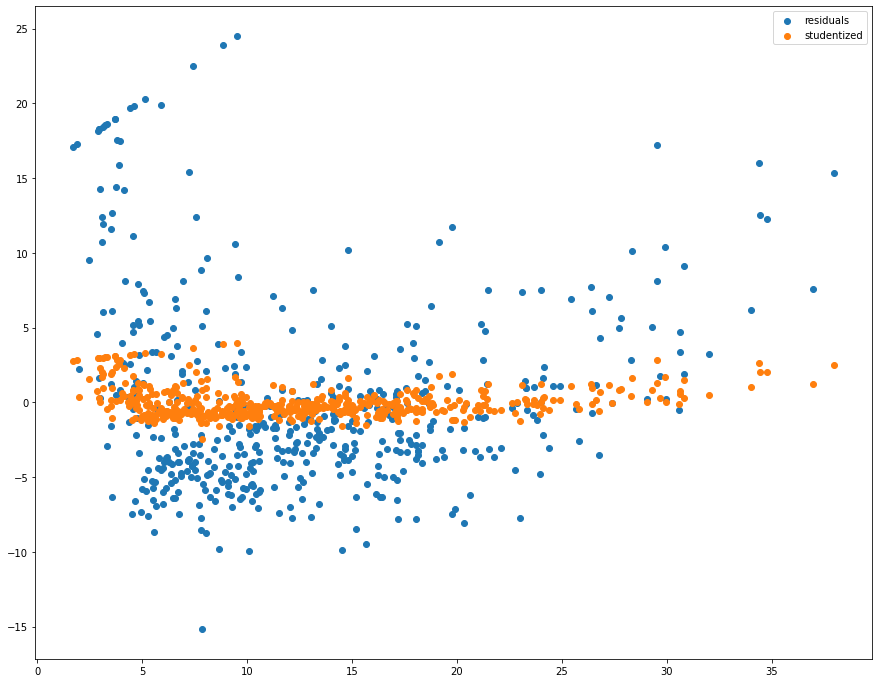

In [18]:
_ = plt.figure(figsize=(15, 12))
residuals = data.medv - medv_on_lstat.predict(data.lstat.values.reshape(-1, 1))
plt.scatter(data.lstat, residuals, label='residuals')
studentized = mod.get_influence().resid_studentized_external
plt.scatter(data.lstat, studentized, label='studentized')
plt.legend()

374

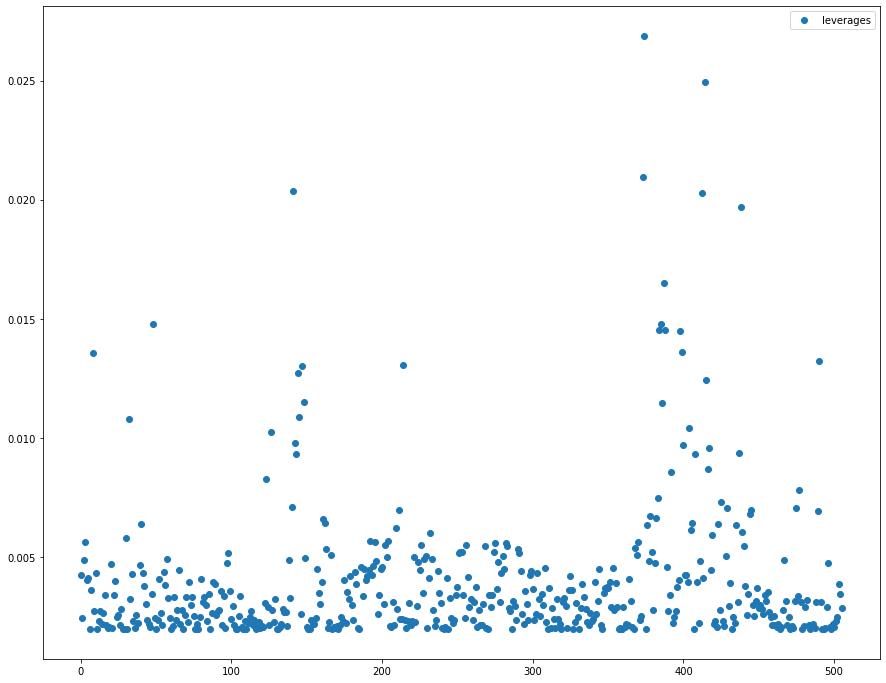

In [17]:
_ = plt.figure(figsize=(15, 12))
hat_values = mod.get_influence().hat_matrix_diag
plt.plot(hat_values, 'o', label='leverages')
plt.legend()
hat_values.argmax()

In [32]:
medv_on_two = LinearRegression().fit(data.loc[:, ['lstat', 'age']], data.medv)
medv_on_two.coef_, medv_on_two.intercept_

(array([-1.03206856,  0.03454434]), 33.2227605317929)

In [33]:
results = report_model(medv_on_two, data.loc[:, ['lstat', 'age']], data.medv)

Residual stats: count    5.060000e+02
mean    -9.885812e-15
std      6.160900e+00
min     -1.598124e+01
25%     -3.977470e+00
50%     -1.283443e+00
75%      1.968309e+00
max      2.315842e+01
Name: medv, dtype: float64
RSS: 19168.128608760813
TSS: 42716.29541501976
R squared: 0.5512689379421002
F_score: 308.9693351215988
Sigma squared estimation: 38.107611548232235
RSE: 6.173136281359114
Betha variance estimation: [[ 2.32234647e-03 -3.54870254e-04 -5.04960415e-03]
 [-3.54870254e-04  1.49462036e-04 -5.75914861e-03]
 [-5.04960415e-03 -5.75914861e-03  5.34137493e-01]]
SE(beta_hat_0): 0.04819073014948507
SE(beta_hat_1): 0.012225466717807387
SE(beta_hat_2): 0.730847106250871


In [34]:
medv_on_all = LinearRegression().fit(data.drop(['medv'], axis=1), data.medv)
medv_on_all.coef_, medv_on_all.intercept_

(array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
        -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
         3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
        -5.24758378e-01]),
 36.45948838509004)

In [36]:
results = report_model(medv_on_all, data.drop(['medv'], axis=1), data.medv)

Residual stats: count    5.060000e+02
mean    -5.223753e-15
std      4.683822e+00
min     -1.559447e+01
25%     -2.729716e+00
50%     -5.180489e-01
75%      1.777051e+00
max      2.619927e+01
Name: medv, dtype: float64
RSS: 11078.784577954977
TSS: 42716.29541501976
R squared: 0.7406426641094094
F_score: 108.0766661743262
Sigma squared estimation: 22.517854833241824
RSE: 4.745298181699631
Betha variance estimation: [[ 1.08010784e-03 -3.93211613e-05  7.49975845e-05  1.41674163e-03
   7.48388964e-03  3.61613108e-04 -1.45038554e-06  7.65725473e-04
  -5.82087835e-04  1.46457971e-06  9.00625513e-05  1.03642927e-05
  -2.54517638e-04 -1.07974757e-02]
 [-3.93211613e-05  1.88443200e-04  8.97733411e-05 -1.74615590e-04
   1.87656747e-03 -8.93823328e-04  2.18802537e-05 -1.10252840e-03
   9.63750012e-05 -1.15220593e-05  5.58841348e-04 -4.20703630e-07
  -3.69897503e-05 -1.63910252e-03]
 [ 7.49975845e-05  8.97733411e-05  3.78171976e-03 -5.45752327e-03
  -6.20060717e-02  2.36268966e-03 -8.95146683e-07 

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [43]:
complete_model = sm.OLS(data.medv, data.drop(['medv'], axis=1)).fit()

In [59]:
X = sm.add_constant(data.drop(['medv'], axis=1))
[(col, variance_inflation_factor(X.to_numpy(), i)) for i, col in enumerate(X.columns)]

[('const', 585.2652379423121),
 ('crim', 1.7921915474332413),
 ('zn', 2.298758178749441),
 ('indus', 3.9915964183460297),
 ('chas', 1.0739953275537886),
 ('nox', 4.393719847577493),
 ('rm', 1.9337444357832565),
 ('age', 3.1008255128153372),
 ('dis', 3.95594490637273),
 ('rad', 7.484496335274472),
 ('tax', 9.00855394759707),
 ('ptratio', 1.7990840492488984),
 ('black', 1.3485210764063753),
 ('lstat', 2.9414910780919366)]

In [64]:
inter_term = pd.Series(data['lstat'] * data['age'], index=data.index, name='lstatxage')
inter_term_X = pd.concat([data['lstat'], data['age'], inter_term], axis=1)
inter_term_reg = LinearRegression().fit(inter_term_X, data.medv)
inter_term_reg.coef_, inter_term_reg.intercept_

(array([-1.39211684e+00, -7.20859509e-04,  4.15595185e-03]), 36.08853593461289)

In [65]:
results = report_model(inter_term_reg, inter_term_X, data.medv)

Residual stats: count    5.060000e+02
mean    -7.133512e-15
std      6.130223e+00
min     -1.580652e+01
25%     -4.044681e+00
50%     -1.333163e+00
75%      2.084707e+00
max      2.755206e+01
Name: medv, dtype: float64
RSS: 18977.716144585767
TSS: 42716.29541501976
R squared: 0.5557265450993935
F_score: 209.3115719328825
Sigma squared estimation: 37.804215427461685
RSE: 6.148513269682492
Betha variance estimation: [[ 2.80413551e-02  2.16883360e-03 -2.97081836e-04 -2.09864955e-01]
 [ 2.16883360e-03  3.95181421e-04 -2.90979029e-05 -2.57780274e-02]
 [-2.97081836e-04 -2.90979029e-05  3.42914516e-06  2.36459906e-03]
 [-2.09864955e-01 -2.57780274e-02  2.36459906e-03  2.16041629e+00]]
SE(beta_hat_0): 0.16745553177429914
SE(beta_hat_1): 0.019879170528411972
SE(beta_hat_2): 0.001851795117820738
SE(beta_hat_3): 1.4698354633791413


In [80]:
squared_term = pd.Series(data['lstat'] * data['lstat'], index=data.index, name='lstat^2')
squared_term_X = pd.concat([data['lstat'], squared_term], axis=1)
squared_term_reg = LinearRegression().fit(squared_term_X, data.medv)
squared_term_reg.coef_, squared_term_reg.intercept_

(array([-2.3328211 ,  0.04354689]), 42.862007328169355)

In [81]:
results = report_model(squared_term_reg, squared_term_X, data.medv)

Residual stats: count    5.060000e+02
mean    -1.449170e-14
std      5.512765e+00
min     -1.528340e+01
25%     -3.831307e+00
50%     -5.295002e-01
75%      2.309535e+00
max      2.541481e+01
Name: medv, dtype: float64
RSS: 15347.24315838198
TSS: 42716.29541501976
R squared: 0.640716897163661
F_score: 448.50508795027736
Sigma squared estimation: 30.511417809904533
RSE: 5.523714131805205
Betha variance estimation: [[ 1.53272583e-02 -4.45380824e-04 -9.99640925e-02]
 [-4.45380824e-04  1.40261396e-05  2.67600060e-03]
 [-9.99640925e-02  2.67600060e-03  7.60531189e-01]]
SE(beta_hat_0): 0.12380330503747428
SE(beta_hat_1): 0.003745148802961689
SE(beta_hat_2): 0.8720843930211493


In [82]:
squared_mod = sm.OLS(data.medv, sm.add_constant(squared_term_X)).fit()

In [83]:
from statsmodels.stats.anova import anova_lm

In [84]:
anova_lm(mod, squared_mod)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,503.0,15347.243158,1.0,4125.13826,135.199822,7.630116e-28


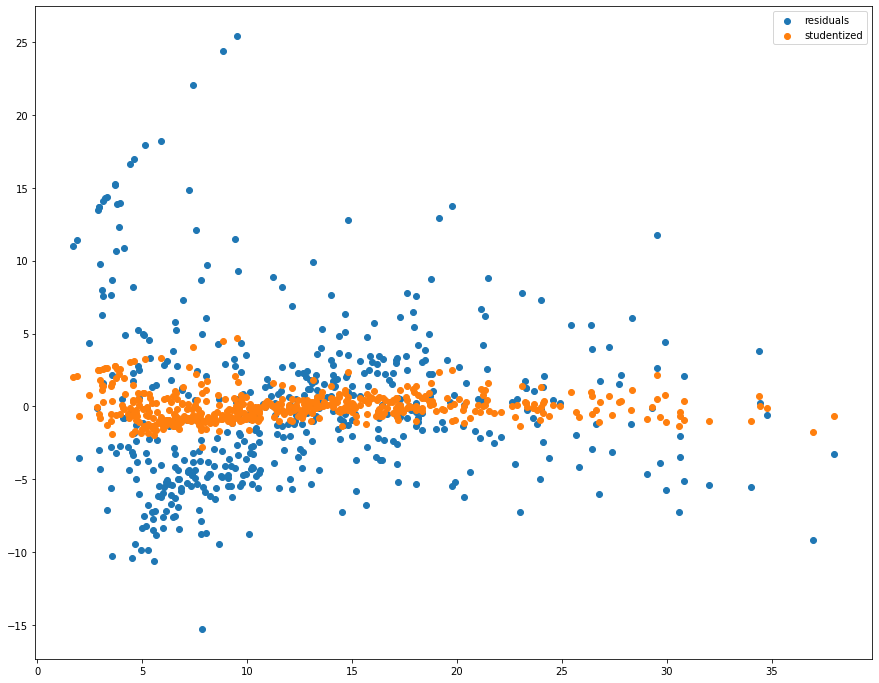

In [85]:
_ = plt.figure(figsize=(15, 12))
residuals = data.medv - squared_term_reg.predict(squared_term_X)
plt.scatter(data.lstat, residuals, label='residuals')
studentized = squared_mod.get_influence().resid_studentized_external
plt.scatter(data.lstat, studentized, label='studentized')
plt.legend()

In [92]:
power_2_term = pd.Series(data['lstat'] ** 2, index=data.index, name='lstat^2')
power_3_term = pd.Series(data['lstat'] ** 3, index=data.index, name='lstat^3')
power_4_term = pd.Series(data['lstat'] ** 4, index=data.index, name='lstat^4')
power_5_term = pd.Series(data['lstat'] ** 5, index=data.index, name='lstat^5')
poly_X = pd.concat([data['lstat'], power_2_term, power_3_term, power_4_term, power_5_term], axis=1)
poly_reg = LinearRegression().fit(poly_X, data.medv)
poly_reg.coef_, poly_reg.intercept_

(array([-1.19911168e+01,  1.27281826e+00, -6.82738394e-02,  1.72606825e-03,
        -1.63199416e-05]),
 67.69967680147366)

In [93]:
results = report_model(poly_reg, poly_X, data.medv)

Residual stats: count    5.060000e+02
mean    -1.046997e-13
std      5.188913e+00
min     -1.354329e+01
25%     -3.103925e+00
50%     -7.052316e-01
75%      2.084364e+00
max      2.711526e+01
Name: medv, dtype: float64
RSS: 13597.035027465221
TSS: 42716.29541501976
R squared: 0.6816897416931835
F_score: 214.15889808870335
Sigma squared estimation: 27.194070054930442
RSE: 5.21479338564151
Betha variance estimation: [[ 2.32781538e+00 -3.35454671e-01  2.09335319e-02 -5.83380338e-04
   5.94205266e-06 -5.35152709e+00]
 [-3.35454671e-01  4.98034821e-02 -3.17963255e-03  9.01628399e-05
  -9.30747059e-07  7.43610084e-01]
 [ 2.09335319e-02 -3.17963255e-03  2.06849804e-04 -5.95464863e-06
   6.22188629e-08 -4.52424014e-02]
 [-5.83380338e-04  9.01628399e-05 -5.95464863e-06  1.73609688e-07
  -1.83338770e-09  1.23803058e-03]
 [ 5.94205266e-06 -9.30747059e-07  6.22188629e-08 -1.83338770e-09
   1.95407334e-11 -1.24401658e-05]
 [-5.35152709e+00  7.43610084e-01 -4.52424014e-02  1.23803058e-03
  -1.244016

In [94]:
log_term = pd.Series(np.log(data['lstat']), index=data.index, name='log(lstat)')
log_X = pd.concat([data['lstat'], log_term], axis=1)
log_reg = LinearRegression().fit(log_X, data.medv)
log_reg.coef_, log_reg.intercept_

(array([  0.38043821, -16.74909763]), 57.43062469481366)

In [95]:
results = report_model(log_reg, log_X, data.medv)

Residual stats: count    5.060000e+02
mean    -1.123388e-16
std      5.247671e+00
min     -1.395285e+01
25%     -3.405554e+00
50%     -5.632813e-01
75%      2.405699e+00
max      2.670371e+01
Name: medv, dtype: float64
RSS: 13906.713552994377
TSS: 42716.29541501976
R squared: 0.6744400838630649
F_score: 521.0152499861672
Sigma squared estimation: 27.647541854859597
RSE: 5.258092986517032
Betha variance estimation: [[ 0.00986707 -0.11069843  0.13761341]
 [-0.11069843  1.39354843 -1.90338052]
 [ 0.13761341 -1.90338052  2.82625719]]
SE(beta_hat_0): 0.09933315026245947
SE(beta_hat_1): 1.1804865226514307
SE(beta_hat_2): 1.6811475813843444
